In [1]:
cd /home

/home


In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pretraining

In [9]:
# config

In [24]:
root = './presentation/results/temp/2024-04-24_01-07-33/'

In [25]:
model, config = load_pt_model(os.path.join(root, 'pretraining'))

[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only


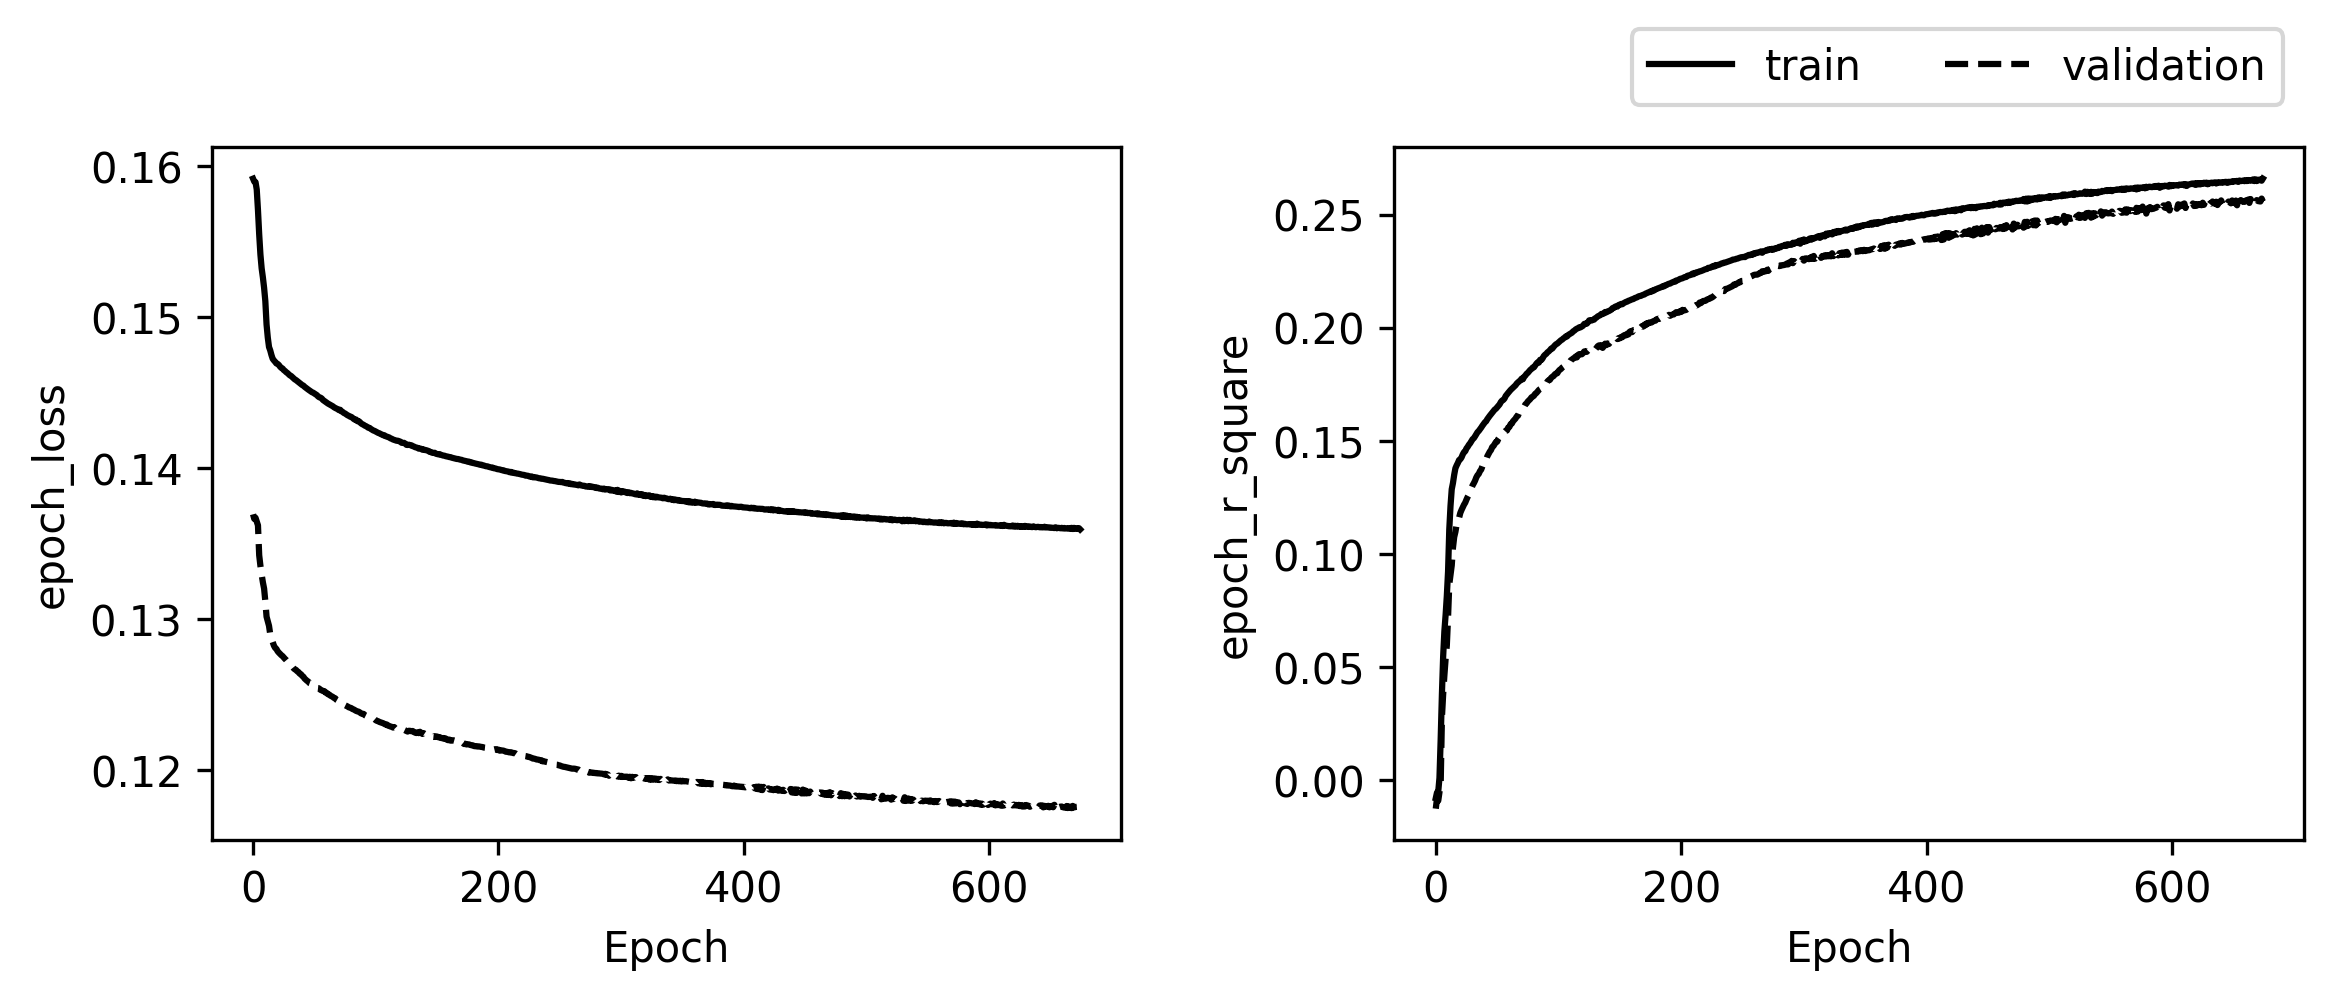

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'wspace':0.3}, dpi=300)

for subset, ls in zip(['train', 'validation'], ['-', '--']):
    for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
        train_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', subset), 
                                    metric_name=metric_name)
        axes[i].plot(train_metrics['step'], train_metrics['value'], label=subset, linestyle=ls, color='k')

#         if metric_name == 'epoch_r_square':
#             axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_r2, test_r2], label=subset+'(ss)')
#             axes[i].text(valid_metrics['step'].iloc[-1]-10, test_r2+0.005, '{:.2f}'.format(test_r2))

#         if metric_name == 'epoch_loss':
#             axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_mse, test_mse], label=subset+'(ss)')
#             axes[i].text(valid_metrics['step'].iloc[-1]-10, test_mse+1e-3, '{:.2f}'.format(test_mse))

        axes[i].set_ylabel(metric_name)
        axes[i].set_xlabel('Epoch')
    
# axes[0].set_title('mse: {:.2f} - r2: {:.2f}'.format(test_mse, test_r2))
axes[-1].legend(bbox_to_anchor=(1., 1.2), ncols=3)
plt.show()

Text(0.5, 1.0, 'True vs Predicted')

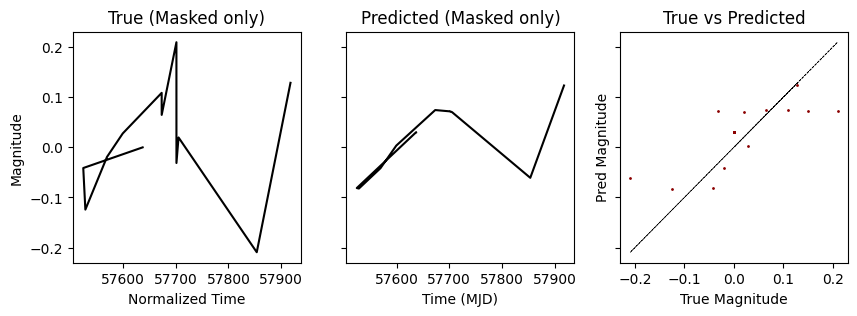

In [29]:
N = 1

x_true = tf.boolean_mask(output['magnitudes'][N], output['mask_in'][N])
x_pred = tf.boolean_mask(output['reconstruction'][N], output['mask_in'][N])
times = tf.boolean_mask(output['times'][N], output['mask_in'][N])

fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.2}, sharey=True)
axes[0].plot(times, x_true, color='k', label='True')
axes[0].set_title('True (Masked only)')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlabel('Normalized Time')
axes[1].plot(times, x_pred, color='k', label='Prediction')
axes[1].set_title('Predicted (Masked only)')
axes[1].set_xlabel('Time (MJD)')
axes[2].scatter(x_true, x_pred, s=1, color='darkred')
axes[2].plot(x_true, x_true, linewidth=0.5, color='k', linestyle='--')

axes[2].set_xlabel('True Magnitude')
axes[2].set_ylabel('Pred Magnitude')
axes[2].set_title('True vs Predicted')

## Finetunem (MLFlow)

In [38]:
runs_df = mlflow.search_runs(experiment_ids=['334210612378422708'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']
runs_df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.val_loss', 'metrics.test_recall', 'metrics.loss',
       'metrics.validation_loss',
       ...
       'tags.pe_dim', 'tags.mlflow.source.type', 'tags.mixer',
       'tags.correct_loss', 'tags.mlflow.runName', 'tags.mlflow.user',
       'tags.num_layers', 'tags.dropout', 'tags.use_leak', 'tags.probed'],
      dtype='object', length=104)

In [39]:
# id_cols = ['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']
    
# selected = runs_df[id_cols+['tags.fold', 'metrics.val_rmse', 'metrics.test_r2']]

# selected.groupby(id_cols).agg({'metrics.val_rmse': ['mean', 'std'],
#                                                                           'metrics.test_r2': ['mean', 'std']})

## Classification (MLFlow)

In [11]:
runs_df = mlflow.search_runs(experiment_ids=['282831345984479080'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']

runs_df = runs_df[['tags.downstream_data', 'params.mask_format','params.loss_format','tags.temperature', 'params.correct_loss', 'params.norm', 'tags.m_alpha', 
                   'tags.probed', 'tags.rs', 'tags.same', 'tags.spc', 'params.clf_name',
                   'tags.fold', 'metrics.test_f1']]
runs_df['tags.fold'] = runs_df['tags.fold'].astype(float)
runs_df['metrics.test_f1'] = runs_df['metrics.test_f1'].astype(float)
runs_df = runs_df[~runs_df['tags.downstream_data'].isna()]
# runs_df['params.clf_name']

In [12]:
runs_df['params.loss_format'] = runs_df['params.loss_format'].astype('string')

In [13]:
grouped = runs_df.groupby(
    ['tags.downstream_data', 'params.correct_loss','params.loss_format', 'tags.temperature', 'params.mask_format', 'params.norm', 'params.clf_name',
     'tags.m_alpha', 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']).agg({'metrics.test_f1': ['mean', 'std']})

/tmp/ipykernel_3889019/3245020642.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['f1'] = np.round(mss, 2)
/tmp/ipykernel_3889019/3245020642.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alpha'] = df['alpha'].replace({'-1000000000.0': '-inf'})
/tmp/ipykernel_3889019/3245020642.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

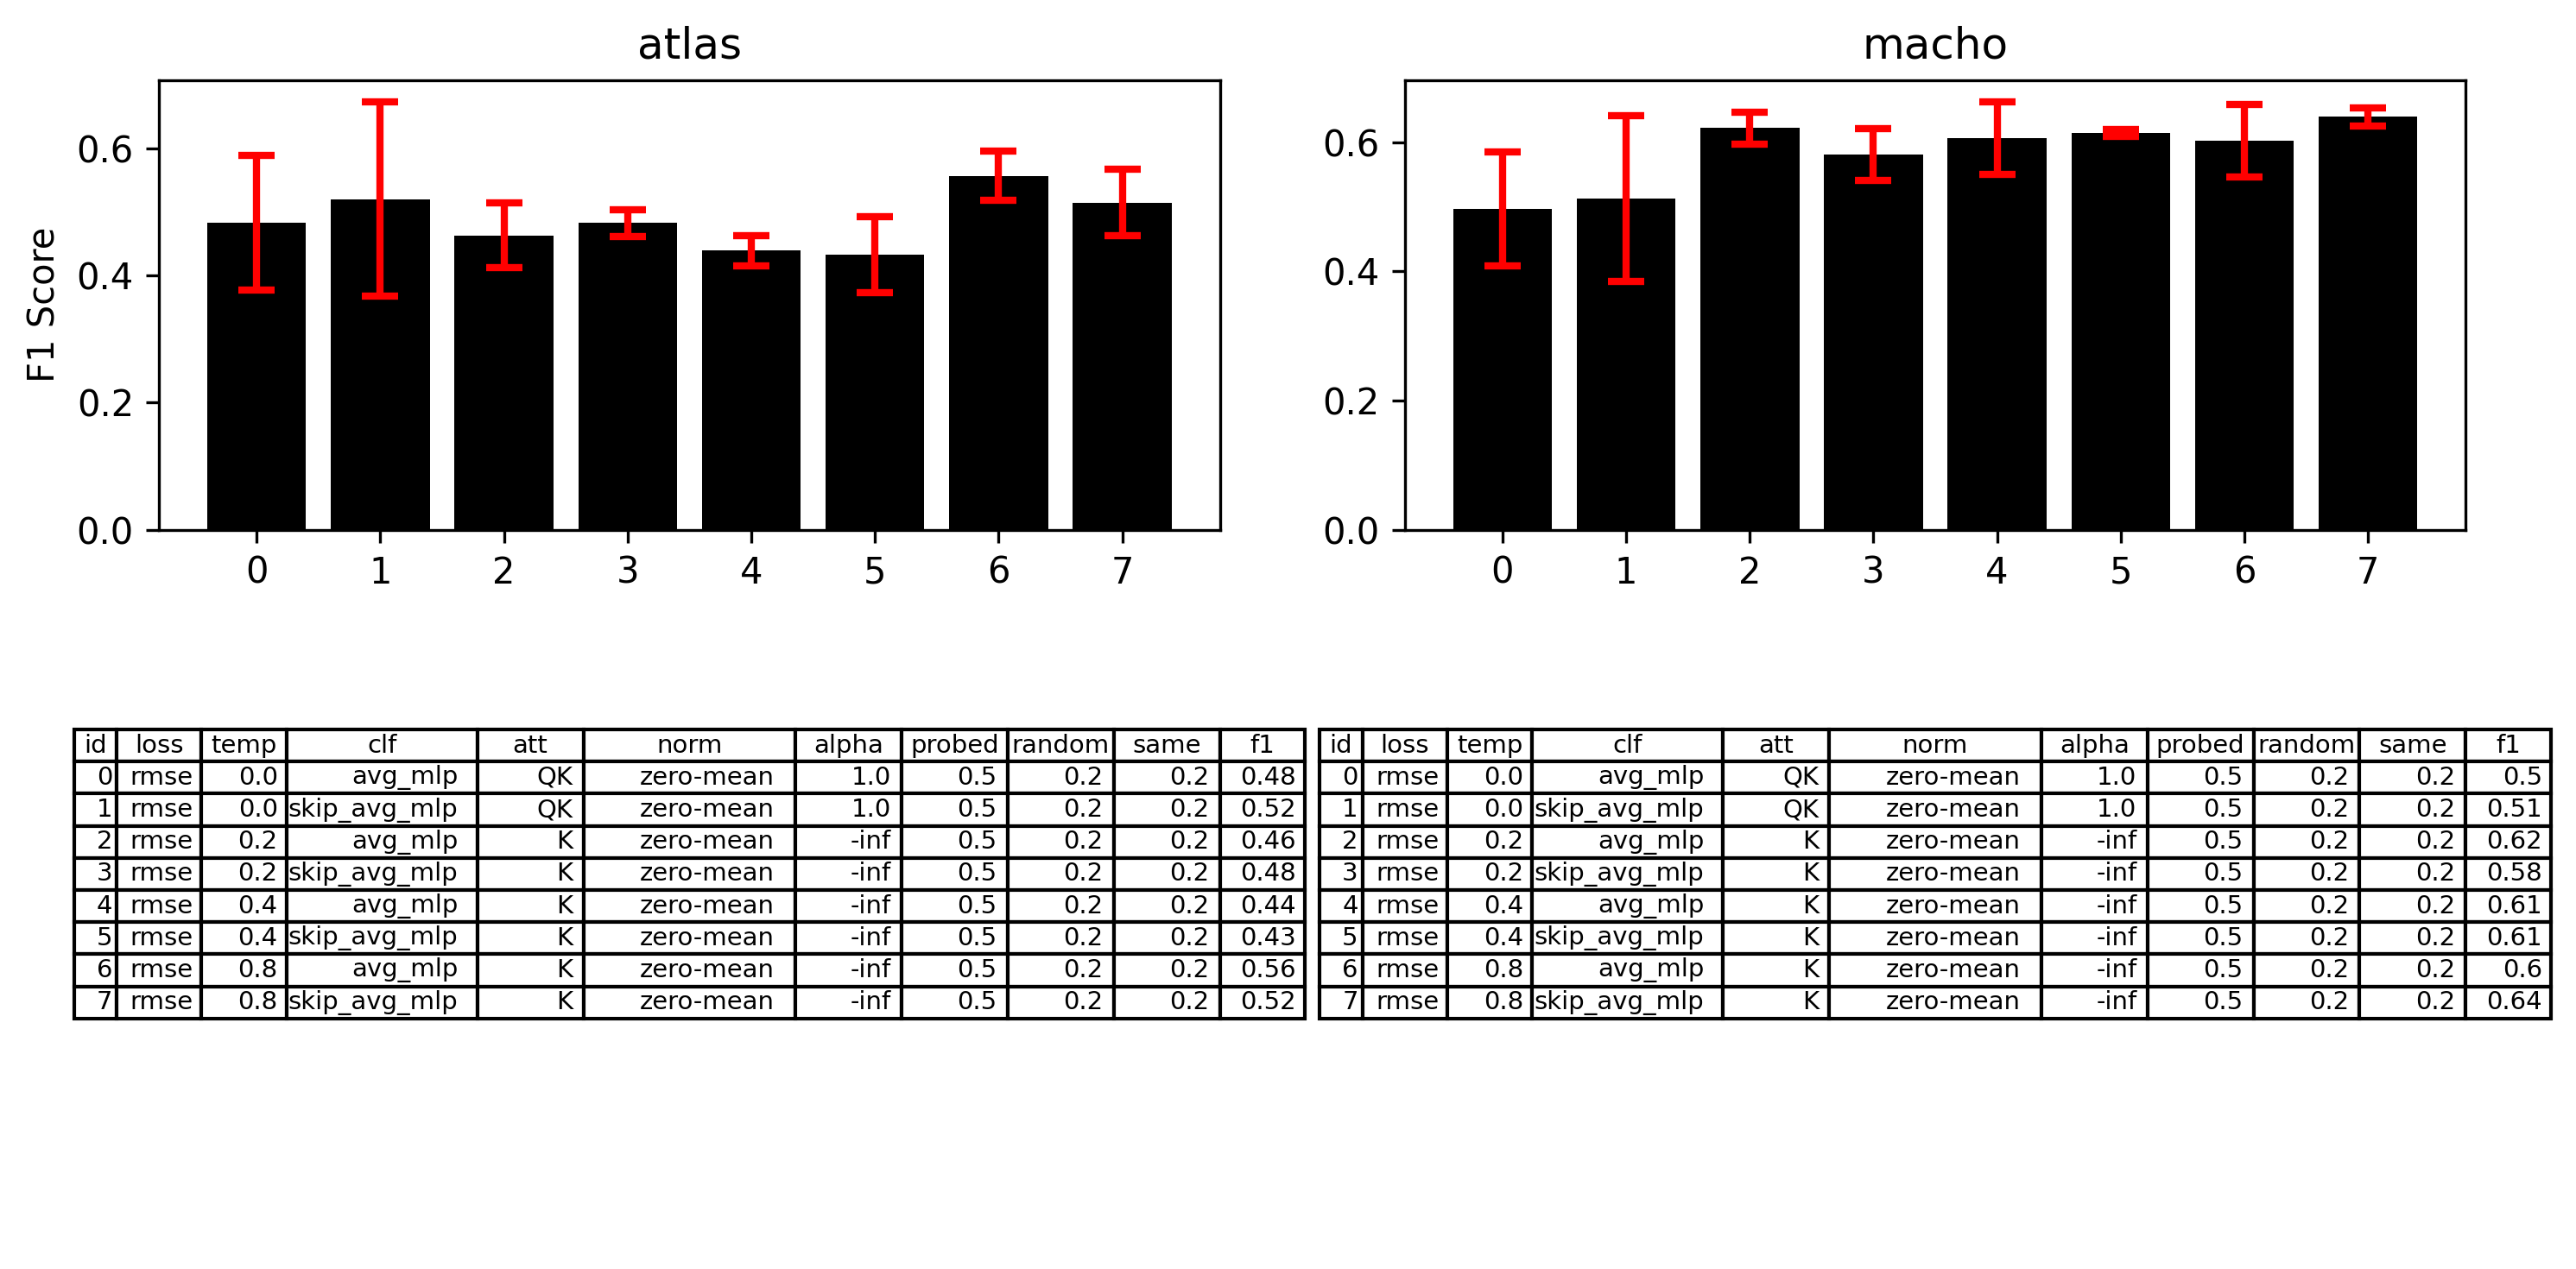

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

# fig.patch.set_visible(False)
for i, (ds_name, frame) in enumerate(grouped.reset_index().groupby('tags.downstream_data')):
    frame = frame[frame['tags.spc']=='500']

    axes[0, i].bar(range(frame.shape[0]), frame['metrics.test_f1']['mean'], 
                   yerr=frame['metrics.test_f1']['std'], color='k',
                   error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2))
    axes[0, i].set_title(ds_name)
    axes[0, i].set_xticks(range(frame.shape[0]))
    frame.index = range(len(frame))
    frame = frame.reset_index()

    mss = frame['metrics.test_f1']['mean']
    df = frame[['index', 
                'params.loss_format',
                'tags.temperature',
                'params.clf_name', 
                'params.mask_format', 
                'params.norm', 
                'tags.m_alpha', 
                'tags.probed', 
                'tags.rs', 
                'tags.same', 
                ]]
    
    df['f1'] = np.round(mss, 2)
    df.columns = ['id','loss', 'temp', 'clf', 'att', 'norm', 'alpha', 'probed', 'random', 'same', 'f1']
    
    df['alpha'] = df['alpha'].replace({'-1000000000.0': '-inf'})
    tab = axes[1, i].table(cellText=df.values, 
                           colWidths=[0.02, 0.04,0.04, 0.09, 0.05, 0.1, 0.05, 0.05, 0.05, 0.05, 0.04],
                           colLabels=df.columns, 
                           loc='top')
    axes[1, i].axis('tight')
    axes[1, i].axis('off')
    
    tab.auto_set_font_size(False)
    tab.set_fontsize(7.)
    tab.scale(2, 1)
    axes[0, 0].set_ylabel('F1 Score')
fig.tight_layout()

In [ ]:
# continum -> logits make more sense it is the same as logits with high temperature
# do experiments with high temperature
# visualize attention of a single observation